In [8]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [24]:
DEVICE = 'cuda' # 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# Coffee beans: 

In [9]:
tform = T.Compose([T.Resize((224, 224)),T.ToTensor()])

In [11]:
train_dataset = torchvision.datasets.ImageFolder(
    'data/coffee-beans/train',
    transform=tform
)
valid_dataset = torchvision.datasets.ImageFolder(
    'data/coffee-beans/test/',
    transform=tform
)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [13]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\bradj/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


In [25]:
model.to(device=DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
model.fc = nn.Linear(2048,4)

In [17]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [33]:
class_dict_coffee= {j: i for i, j in train_dataset.class_to_idx.items()}
class_dict_coffee

{0: 'Dark', 1: 'Green', 2: 'Light', 3: 'Medium'}

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

def torch_train(
        model: nn.Module, 
        epochs: int, 
        optimizer: torch.optim.Optimizer, 
        history = None,
        silent = False
        ) -> dict:
    '''
    model: pytorch model - model to train
    epochs: int          - number of epochs
    '''

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        if not silent: print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = [] 
        for samples, labels in train_loader: 
            
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            y_pred = model(samples)
            

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            batch_accs.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        model.eval()
    
        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(samples.to(DEVICE))
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))
        
        
        if not silent: 
            print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
            print(f'{"-"*35}')
            print()
    

    return history

In [27]:
torch_train(model, 10, optimizer)

------------- Epoch 1 -------------
train: accuracy 0.8939, loss 0.4242
valid: accuracy 0.9784, loss 0.1500
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.9836, loss 0.1083
valid: accuracy 0.9904, loss 0.0641
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.9827, loss 0.0786
valid: accuracy 1.0000, loss 0.0359
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.9959, loss 0.0532
valid: accuracy 1.0000, loss 0.0263
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.9926, loss 0.0425
valid: accuracy 1.0000, loss 0.0180
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.9951, loss 0.0327
valid: accuracy 0.9952, loss 0.0171
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.9951, loss 0.0317
valid: accuracy 0.9976, loss 0.0143
----------------------

{'train_accs': [0.8939144736842105,
  0.9835526315789473,
  0.9827302631578947,
  0.9958881578947368,
  0.9925986842105263,
  0.9950657894736842,
  0.9950657894736842,
  0.9983552631578947,
  1.0,
  1.0],
 'train_losses': [0.4241979941725731,
  0.10828270547484097,
  0.07859262931895883,
  0.05316360939392134,
  0.042546059789234085,
  0.03274297047602503,
  0.03173150584150694,
  0.021996059994164267,
  0.019693794660270214,
  0.020297412625759056],
 'valid_accs': [0.9783653846153846,
  0.9903846153846154,
  1.0,
  1.0,
  1.0,
  0.9951923076923077,
  0.9975961538461539,
  0.9975961538461539,
  0.9975961538461539,
  0.9975961538461539],
 'valid_losses': [0.15002009501824012,
  0.06411608709738804,
  0.035932958555909306,
  0.02634456861191071,
  0.0179666058661846,
  0.01705132141852608,
  0.014272303678668462,
  0.016049819640242137,
  0.013005593719963845,
  0.009655175282834815]}

In [28]:
torch.save(model.state_dict(), 'coffe_save.pt')

# 2 classifiers:

In [29]:
from torchvision.models import vgg19, VGG19_Weights
model_1 = vgg19(weights=VGG19_Weights.DEFAULT)

model_2 = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\bradj/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


In [ ]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [40]:
labels = json.load(open('imagenet_class_index.json'))
decode = lambda x: labels[str(x)][1]

In [59]:
def double_classify(img): 
    pred1 = model_1(img.unsqueeze(0)).softmax(dim=1)
    pred2 = model_2(img.unsqueeze(0)).softmax(dim=1)
    
    pred_vote = (pred1 + pred2)/2
    
    
    sorted, indices = torch.sort(pred_vote, descending=True)
    
    top_5 = sorted.tolist()[0][:5]
    top_5_i = indices.tolist()[0][:5]
    top_5_n = list(map(decode, top_5_i))
    
    return top_5_n, top_5

# Image tests

In [32]:
resize = T.Resize((224, 224))

In [38]:
img = resize(io.read_image('test/img2.jpg')/255)

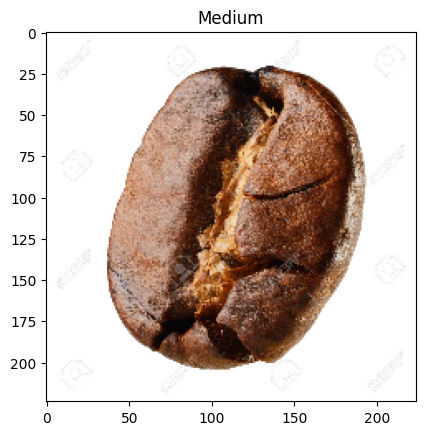

In [39]:
model.eval()
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.title(class_dict_coffee[model(img.to(DEVICE).unsqueeze(0)).softmax(dim=1).argmax().tolist()]);

__________


tensor(1.0000, grad_fn=<SumBackward0>)


(['tabby', 'Egyptian_cat', 'tiger_cat', 'lynx', 'paper_towel'],
 [0.22523605823516846,
  0.13613489270210266,
  0.11673945188522339,
  0.00929701142013073,
  0.0032992069609463215])

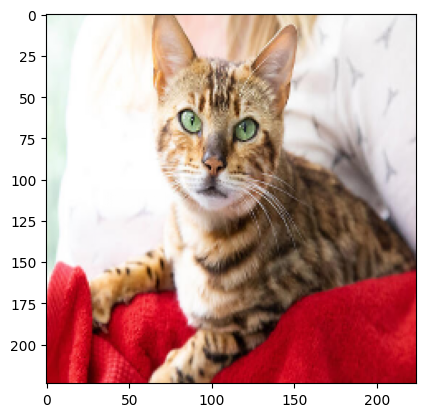

In [60]:
img = resize(io.read_image('test/img4.jpg')/255)
plt.imshow(torch.permute(img, (1, 2, 0)))
double_classify(img)